In [1]:
from preprocessing.load_data import download_and_load_sts_data, download_and_load_sick_dataset

sts_dev, sts_test = download_and_load_sts_data()
sts_test[:10]


,sent_1,sent_2,sim
0,A girl is styling her hair.,A girl is brushing her hair.,2.500
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.600
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.000
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.200
4,A man is playing a harp.,A man is playing a keyboard.,1.500
5,A woman is cutting onions.,A woman is cutting tofu.,1.800
6,A man is riding an electric bicycle.,A man is riding a bicycle.,3.500
7,A man is playing the drums.,A man is playing the guitar.,2.200
8,A man is playing guitar.,A lady is playing the guitar.,2.200
9,A man is playing a guitar.,A man is playing a trumpet.,1.714


In [2]:
sick_all, sick_train, sick_test, sick_dev = download_and_load_sick_dataset()
sick_all[:10]

,idx,sent_1,sent_2,sim,label
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL
5,12,Two dogs are fighting,Two dogs are wrestling and hugging,4.0,NEUTRAL
6,14,A brown dog is attacking another animal in fro...,Two dogs are fighting,3.5,NEUTRAL
7,18,A brown dog is attacking another animal in fro...,Two dogs are wrestling and hugging,3.2,NEUTRAL
8,25,Nobody is riding the bicycle on one wheel,A person in a black jacket is doing tricks on ...,2.8,NEUTRAL
9,26,A person is riding the bicycle on one wheel,A man in a black jacket is doing tricks on a m...,3.7,NEUTRAL


In [3]:
from embeddings.load_embeddings import load_word2vec
word2vec = load_word2vec("/data/word2vec/GoogleNews-vectors-negative300.bin.gz")

In [4]:
from embeddings.load_embeddings import load_glove
glove = load_glove("/data/glove/glove.840B.300d.txt")

In [5]:
from utility.frequency_loader import load_frequencies, load_doc_frequencies

frequency = load_frequencies("/data/frequencies/frequencies.tsv")
doc_frequency = load_doc_frequencies("/data/frequencies/doc_frequencies.tsv")

In [50]:
import functools as ft
from preprocessing.normalize import normalize
from matrices.avg_embeddings import run_avg_benchmark
from utility.run_experiment import run_experiment
import pandas as pd
import matplotlib.pyplot as plt


benchmarks = ["AVG-W2V", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=False),
              "AVG-W2V-STOP", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=True),
              "AVG-W2V-TFIDF", ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=False, doc_freqs=doc_frequency),
              "AVG-W2V-TFIDF-STOP",ft.partial(run_avg_benchmark, model=word2vec, use_stoplist=True, doc_freqs=doc_frequency),
              "AVG-GLOVE", ft.partial(run_avg_benchmark, model=glove, use_stoplist=False),
              "AVG-GLOVE-STOP", ft.partial(run_avg_benchmark, model=glove, use_stoplist=True),
              "AVG-GLOVE-TFIDF", ft.partial(run_avg_benchmark, model=glove, use_stoplist=False, doc_freqs=doc_frequency),
              "AVG-GLOVE-TFIDF-STOP",ft.partial(run_avg_benchmark, model=glove, use_stoplist=True, doc_freqs=doc_frequency)]


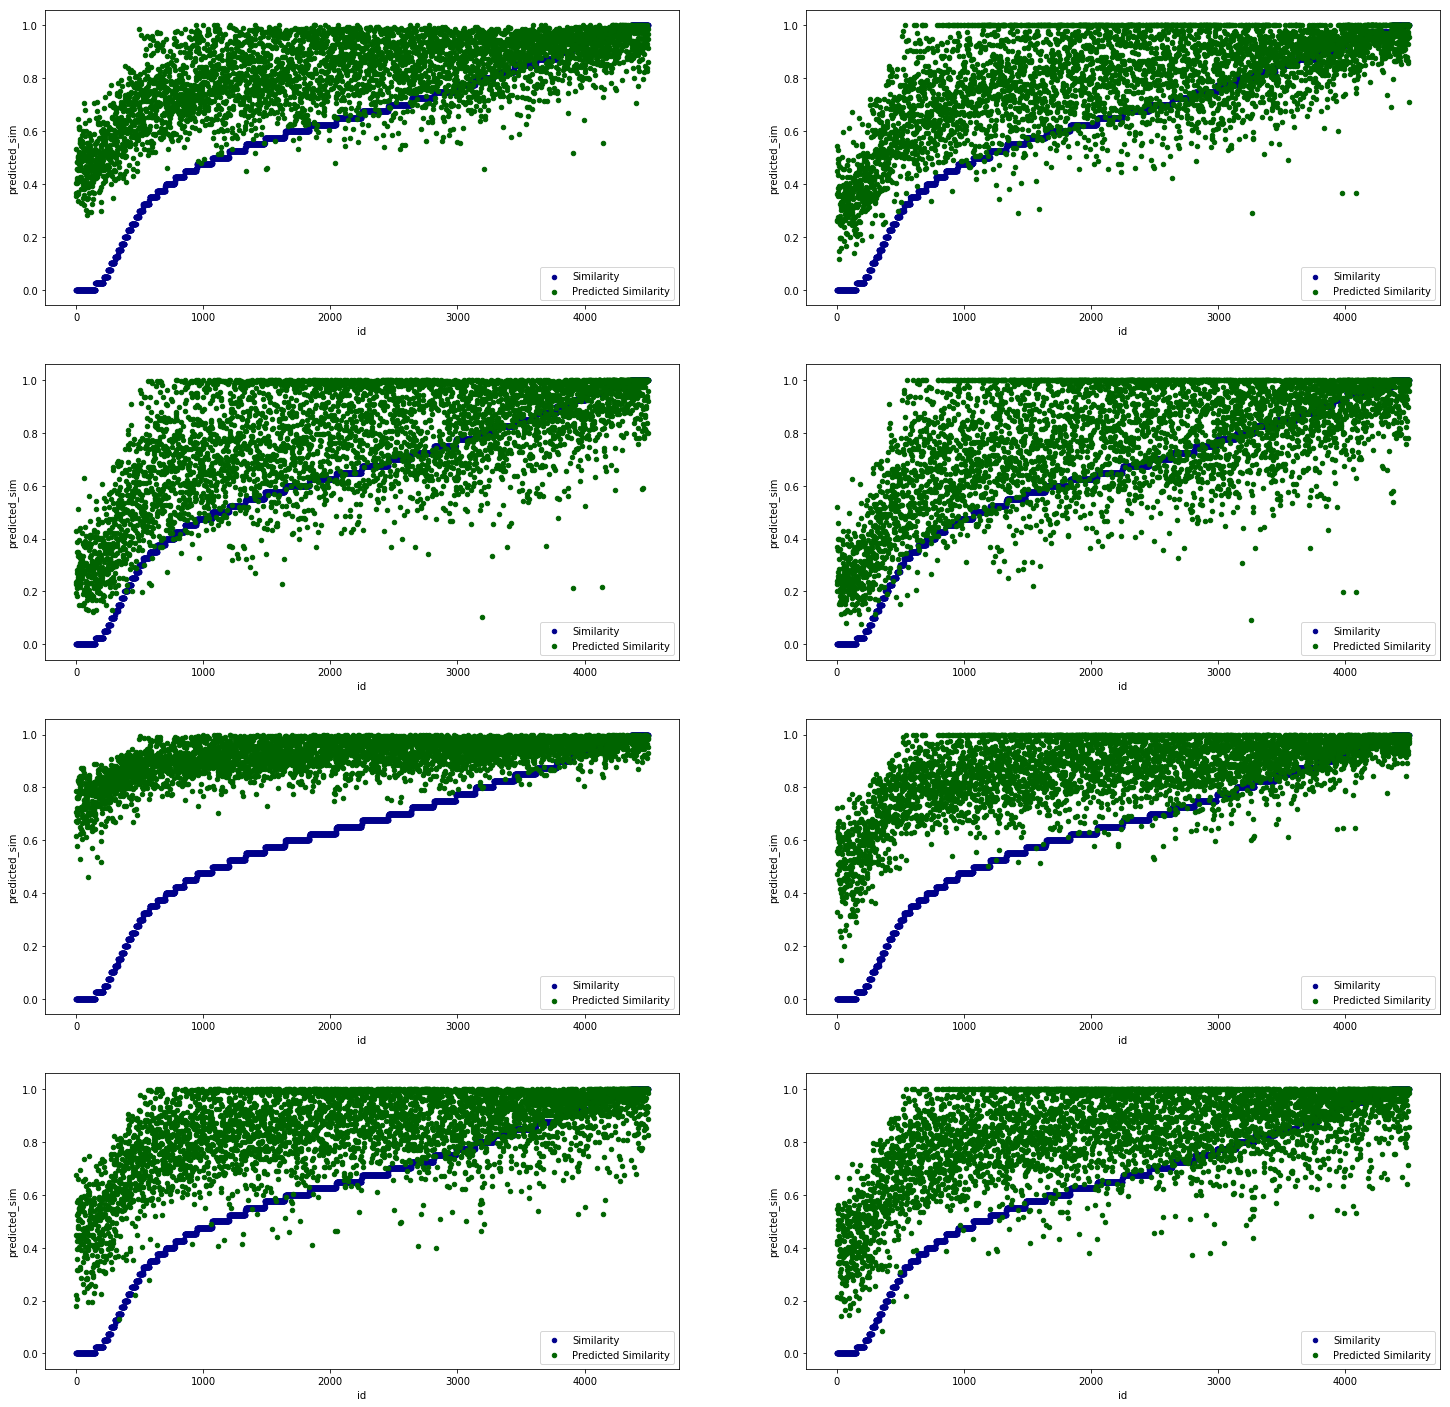

In [51]:

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25,25))
row = 0
column = 0
sick_train = normalize(sick_train, ["sim"])
for i in range(0, 8):
    sims = run_experiment(sick_train, benchmarks[i])
    sick_train['predicted_sim'] = pd.Series(sims).values
    sick_train = sick_train.sort_values('sim')
    id = list(range(0, len(sick_train.index)))
    sick_train['id'] = pd.Series(id).values
    
    if(i < 2):
        row = 0
        column = i
    if(i >= 2 and i < 4):
        row = 1
        column = i-2
    if(i >= 4 and i < 6):
        row = 2
        column = i-4
    if(i >=6 and i < 8):
        row = 3
        column = i-6
        
    sick_train.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', ax=axes[row, column]);
    sick_train.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[row, column]);




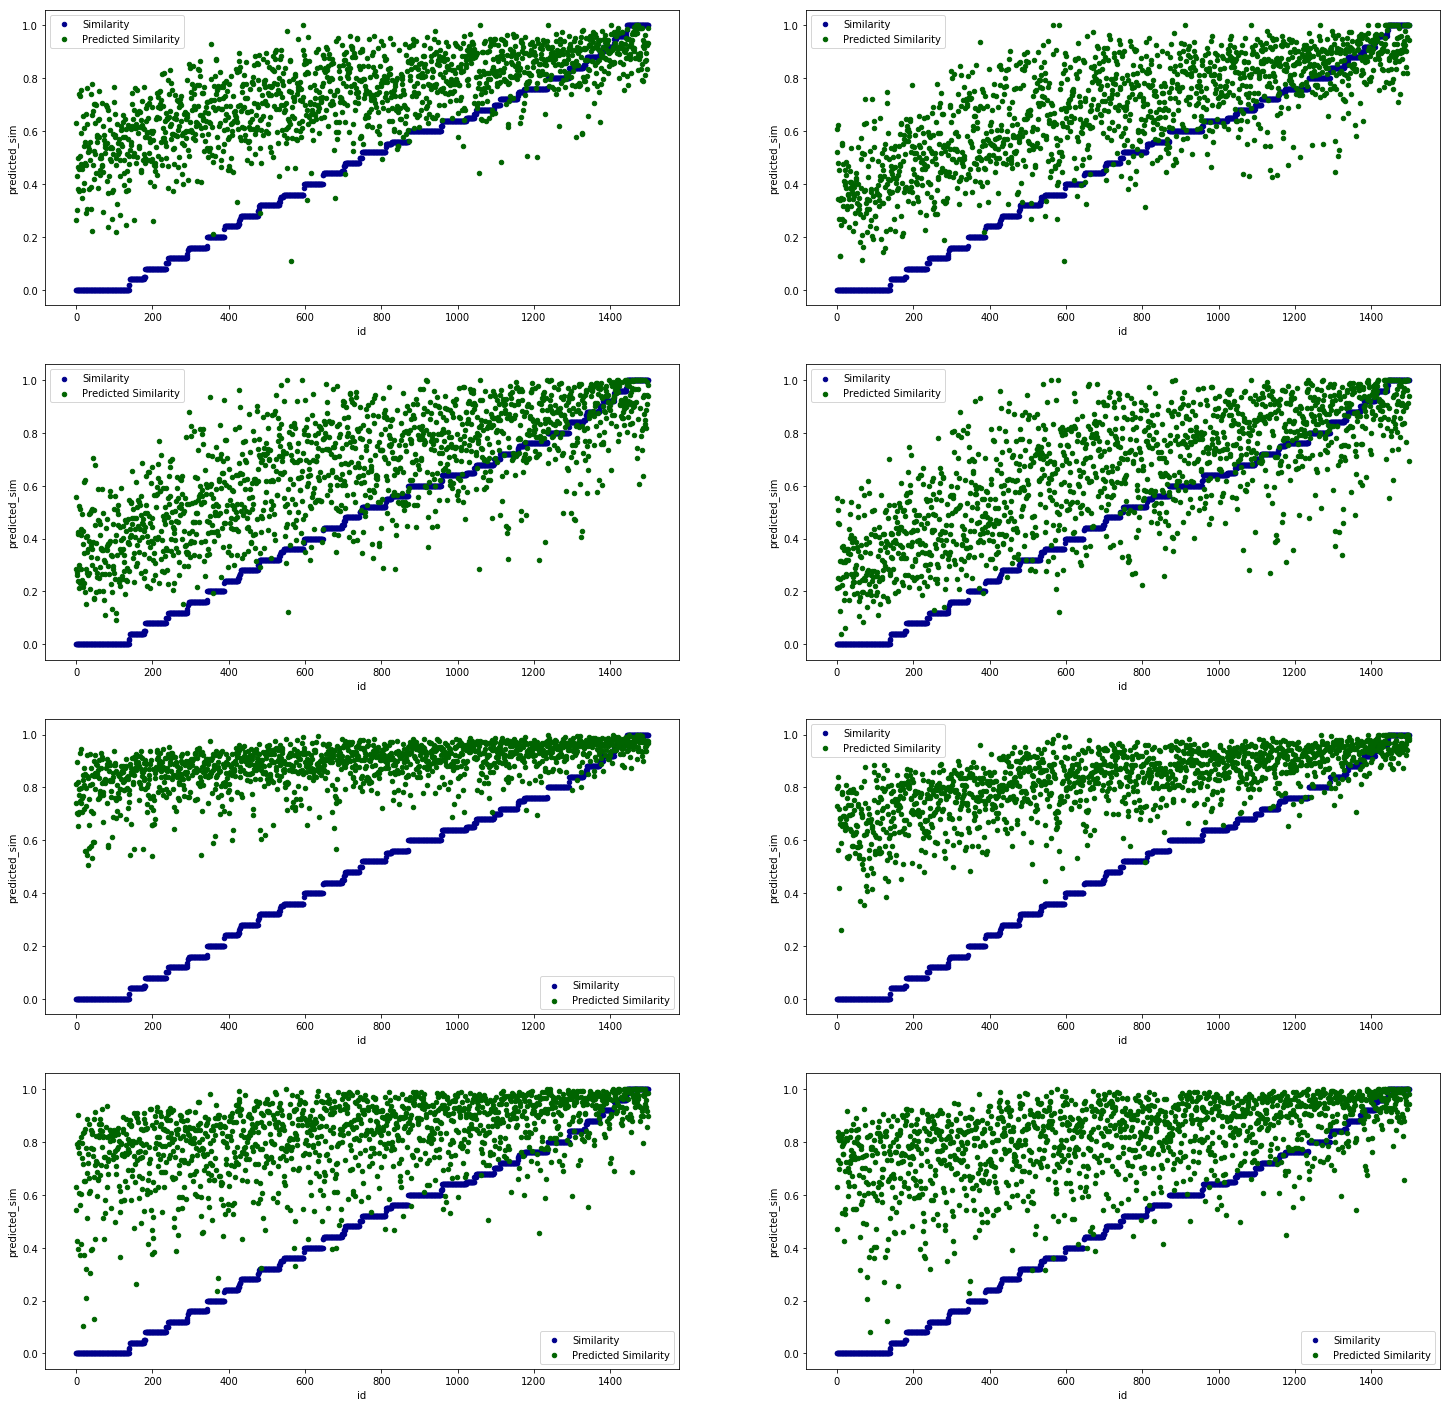

In [52]:

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25,25))
row = 0
column = 0
sts_dev = normalize(sts_dev, ["sim"])
for i in range(0, 8):
    sims = run_experiment(sts_dev, benchmarks[i])
    sts_dev['predicted_sim'] = pd.Series(sims).values
    sts_dev = sts_dev.sort_values('sim')
    id = list(range(0, len(sts_dev.index)))
    sts_dev['id'] = pd.Series(id).values
    
    if(i < 2):
        row = 0
        column = i
    if(i >= 2 and i < 4):
        row = 1
        column = i-2
    if(i >= 4 and i < 6):
        row = 2
        column = i-4
    if(i >=6 and i < 8):
        row = 3
        column = i-6
        
    sts_dev.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', ax=axes[row, column]);
    sts_dev.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[row, column]);


